In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

In [18]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 535) # 535 is the 25% of the frames

100%|██████████| 534/534 [00:08<00:00, 63.18it/s]


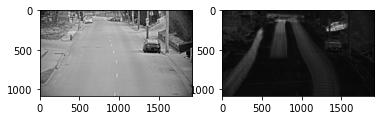

In [19]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(means, cmap='gray')
axs[1].imshow(stds, cmap='gray')

plt.show()

In [96]:
def closing(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def opening(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)


def getBoxesFromMask2(mask):
    # output = cv2.connectedComponentsWithStats(np.uint8(mask), 8, cv2.CV_32S)
    # (numLabels, labels, boxes, centroids) = output
    counts, hier = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    detectedElems = []
    for cont in counts: #First box is always the background
        x,y,w,h = cv2.boundingRect(cont)
        if w*h > 700: #Try to do a better estimation of the minimunm size
            b = VehicleDetection(0, -1, float(x), float(y), float(w), float(h), float(-1))
            detectedElems.append(b)

    return detectedElems


def remove_background2(means, stds, videoPath, ROIpath, alpha=4, sigma=2):
    roi = cv2.imread(ROIpath, cv2.IMREAD_GRAYSCALE)
    
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            img_mask = np.zeros(img_gray.shape, dtype = np.uint8)
            img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

            cleaned = opening(img_mask, 5, 5) #initial removal of small noise
            cleaned = closing(cleaned, 30, 2) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            cleaned = closing(cleaned, 2, 30) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            # cleaned = opening(cleaned, 40, 5) #removal of thin erroneous vertical lines
            # cleaned = closing(cleaned, 100, 100) #filling of gaps
            # cleaned = opening(cleaned, 20, 60 #removing shadows and similars [REVISE]

            roi_applied = cv2.bitwise_and(cleaned, roi)

            cv2.imwrite(f'./masks/mask_{frame}.png', roi_applied)

            detections[str(frame)] = getBoxesFromMask2(roi_applied)
            roi_applied = cv2.cvtColor(roi_applied,cv2.COLOR_GRAY2RGB)
            for b in detections[str(frame)]:
                tl = (int(b.xtl), int(b.ytl))
                br = (int(b.xbr), int(b.ybr))
                color = (255,0,0)
                roi_applied = cv2.rectangle(roi_applied, tl, br, color, 2)
            cv2.imwrite(f'./masks_bb/mask_{frame}.png', roi_applied)

    return detections

In [50]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [97]:
singleGaussianDetections = remove_background2(means, stds, data_path + 'vdo.avi', data_path + 'roi.jpg', 3.8, 2)

 56%|█████▋    | 1206/2141 [00:48<01:02, 14.87it/s]

In [93]:
#split detections in groups of frames
detects_1000 = {}
for frame in range(530,1000):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1000[str(frame)] = singleGaussianDetections[str(frame)]

detects_1000_1500 = {}
for frame in range(1000,1500):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1000_1500[str(frame)] = singleGaussianDetections[str(frame)]

detects_1500_end = {}
for frame in range(1500,2142):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1500_end[str(frame)] = singleGaussianDetections[str(frame)]

In [94]:
recs, precs, aps = ap_wo_conf(gt_detect,detects_1000)
recs2, precs2, aps2 = ap_wo_conf(gt_detect,detects_1000_1500)
recs3, precs3, aps3 = ap_wo_conf(gt_detect,detects_1500_end)


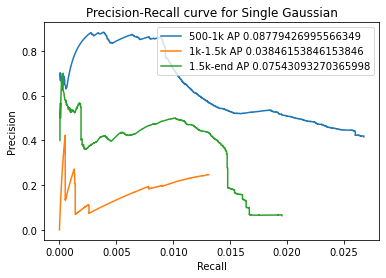

In [95]:
tests = [np.mean(precs, axis=0), np.mean(precs2, axis=0), np.mean(precs3, axis=0)]
labels = [f'500-1k AP {np.mean(aps)}', f'1k-1.5k AP {np.mean(aps2)}', f'1.5k-end AP {np.mean(aps3)}']
plot_multiple_prec_recall_curves(tests, [recs[0], recs2[0], recs3[0]], labels, f'Precision-Recall curve for Single Gaussian')

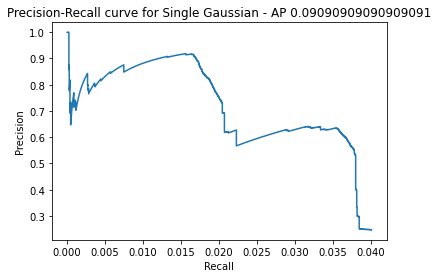

In [32]:
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Single Gaussian - AP {ap}')

100%|██████████| 2141/2141 [01:47<00:00, 19.97it/s]


With Alpha 2.0 the AP is 0.0766384778012685


100%|██████████| 2141/2141 [01:43<00:00, 20.67it/s]


With Alpha 3.857142857142857 the AP is 0.09090909090909091


100%|██████████| 2141/2141 [01:39<00:00, 21.58it/s]


With Alpha 5.714285714285714 the AP is 0.09090909090909091


100%|██████████| 2141/2141 [01:36<00:00, 22.15it/s]


With Alpha 7.571428571428571 the AP is 0.09090909090909091


100%|██████████| 2141/2141 [01:39<00:00, 21.59it/s]


With Alpha 9.428571428571429 the AP is 0.09090909090909091


100%|██████████| 2141/2141 [01:42<00:00, 20.82it/s]


With Alpha 11.285714285714286 the AP is 0.09090909090909091


100%|██████████| 2141/2141 [01:41<00:00, 21.02it/s]


With Alpha 13.142857142857142 the AP is 0.04727272727272727


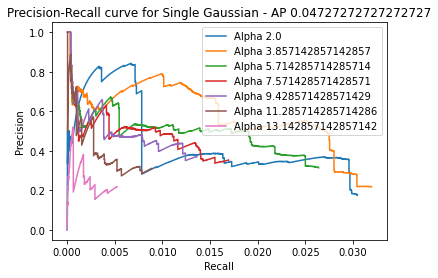

In [9]:
alphas = np.linspace(2.0, 15.0, num=7, endpoint=False)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi', data_path + 'roi.jpg', alpha, 2.0)
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian - AP {ap}')

In [33]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector500-1000', 536, 1000)

 47%|████▋     | 1001/2141 [00:10<00:11, 96.76it/s]


frames 465


In [41]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector1000-1500', 1000, 1500)

 70%|███████   | 1501/2141 [00:14<00:06, 104.33it/s]


frames 501


In [42]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector1500-2000', 1500, 2140)

100%|██████████| 2141/2141 [00:24<00:00, 86.71it/s] 


frames 641
